Please provide the folder containing the soi.dat and recruit.dat datasets:

In [9]:
datafolder = "../data"

Let me check if you provided the correct folder:

In [10]:
import os
has_soi = sum([name.endswith("soi.dat") for name in os.listdir(datafolder)])
has_recruit = sum([name.endswith("recruit.dat") for name in os.listdir(datafolder)])

In [11]:
if (has_soi and has_recruit):
    print 'You are ready to go'
else:
    print 'Found files:'
    print os.listdir(datafolder)
    print ''
if not has_soi:
    print 'You are missing soi.dat'
if not has_recruit:
    print 'You are missing recruit.dat'

You are ready to go


## Setup
The following blocks setup some common functions and load the data.
You can skip it for now:

In [59]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
import pandas as pd
import numpy as np
import os
import scipy as sc
from scipy.ndimage.interpolation import shift
import sklearn
from sklearn import linear_model, model_selection # in old versions use cross_validation
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import make_scorer, r2_score
from sklearn.metrics.scorer import r2_scorer, mean_squared_error_scorer
import statsmodels
from statsmodels.tsa.api import VAR
from bdranalytics.model_selection.growingwindow import GrowingWindow

print "statsmodels: {}".format(statsmodels.__version__)
print "numpy: {}".format(np.__version__)
print "scipy: {}".format(sc.__version__)
print "sklearn: {}".format(sklearn.__version__)
print "pandas: {}".format(pd.__version__)

statsmodels: 0.6.1
numpy: 1.11.1
scipy: 0.18.0
sklearn: 0.18.dev0
pandas: 0.18.1


In [13]:
X_orig = pd.read_csv(os.path.join(datafolder, "soi.dat"), header=0, names=["soi"])
rng=pd.date_range('1/1/1866', periods=X_orig.size, freq='MS')
X_orig = X_orig.set_index(rng)
y_orig = pd.read_csv(os.path.join(datafolder, "recruit.dat"), header=0, names=["recruit"]).set_index(rng).iloc[:,0]

## Some data details

In [14]:
print X_orig.shape
print y_orig.shape
print X_orig.join(y_orig).head()
X_orig.join(y_orig).describe()

(452, 1)
(452,)
                       soi  recruit
1866-01-01 00:00:00  0.246    68.63
1866-02-01 00:00:00  0.311    68.63
1866-03-01 00:00:00  0.104    68.63
1866-04-01 00:00:00 -0.016    68.63
1866-05-01 00:00:00  0.235    68.63


,soi,recruit
count,452.000000,452.000000
mean,0.079381,62.248695
std,0.382915,28.006504
min,-1.000000,1.720000
25%,-0.182750,39.597500
50%,0.115000,68.625000
75%,0.366000,86.860000
max,1.000000,100.000000


## Exercise 1A : Creating features
Now we have 'X_orig' and 'y_orig', please create a new X dataframe, and y series.
The X dataframe should contain all features used to predict, while the y series should be the target variable.
If you use a lagged y to predict y, please use at least lag 1.

Documentation details:

  * http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shift.html
  * http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html


### Provided answer:

In [15]:
# like sklearn's transformers, but then on pandas DataFrame
class PdLagTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lag):
        self.lag = lag
        
    def fit(self, X, y=None, **fit_params):
        return self
        
    def do_transform(self, dataframe):
        return (dataframe.shift(self.lag)
                .rename(columns= lambda c: "{}_lag{}".format(c, self.lag)))

    def transform(self, X):
        try:
            return self.do_transform(X)
        except AttributeError:
            return self.do_transform(pd.DataFrame(X))
        
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X,y).transform(X)
        
    
class PdWindowTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, window, func):
        self.window = window
        self.func = func
        
    def fit(self, X, y=None, **fit_params):
        return self
        
    def do_transform(self, dataframe):
        return (self.func(dataframe.rolling(self.window))
                .rename(columns= lambda c: "{}_window{}".format(c, self.window)))
    
    def transform(self, X):
        try:
            return self.do_transform(X)
        except AttributeError:
            return self.do_transform(pd.DataFrame(X))
        
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X,y).transform(X)

class PdFeatureUnion():
    def __init__(self, union):
        self.union = union
        
    def fit(self, X, y=None, **fit_params):
        return PdFeatureUnion([one.fit(X,y) for one in self.union])
    
    def transform(self, X):
        return pd.concat([one.transform(X) for one in self.union], axis=1, join_axes=[X.index])
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X,y).transform(X)

class PdFeatureChain():
    def __init__(self, chain):
        self.chain = chain
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, y=None, **fit_params):
        result = X
        for element in self.chain:
            result = element.fit_transform(result, y)
        return result
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X,y).transform(X)
    
print PdWindowTransformer(2, lambda x:x.max()).fit_transform(X_orig).head()
print PdLagTransformer(2).fit_transform(y_orig.to_frame()).head()
print PdFeatureUnion([
        PdWindowTransformer(2, lambda x:x.max()),
        PdLagTransformer(2)]
                    ).fit_transform(X_orig).head()
print PdFeatureChain([PdWindowTransformer(2, lambda x:x.max()), PdLagTransformer(2)]).fit_transform(X_orig).head()

                     soi_window2
1866-01-01 00:00:00          NaN
1866-02-01 00:00:00        0.311
1866-03-01 00:00:00        0.311
1866-04-01 00:00:00        0.104
1866-05-01 00:00:00        0.235
                     recruit_lag2
1866-01-01 00:00:00           NaN
1866-02-01 00:00:00           NaN
1866-03-01 00:00:00         68.63
1866-04-01 00:00:00         68.63
1866-05-01 00:00:00         68.63
                     soi_window2  soi_lag2
1866-01-01 00:00:00          NaN       NaN
1866-02-01 00:00:00        0.311       NaN
1866-03-01 00:00:00        0.311     0.246
1866-04-01 00:00:00        0.104     0.311
1866-05-01 00:00:00        0.235     0.104
                     soi_window2_lag2
1866-01-01 00:00:00               NaN
1866-02-01 00:00:00               NaN
1866-03-01 00:00:00               NaN
1866-04-01 00:00:00             0.311
1866-05-01 00:00:00             0.311


In [16]:
window_transformers = PdFeatureUnion([PdWindowTransformer(window, lambda x: x.mean()) for window in range(1,12)])
lag_transformers = PdFeatureUnion([PdLagTransformer(lag) for lag in range(20)])
combined_features = PdFeatureChain([
        window_transformers,
        lag_transformers
        ])

In [17]:
X = pd.concat([X_orig,  # the original features
               PdLagTransformer(1).fit_transform(y_orig.to_frame()) # the target to predict, lagged by 1
              ], axis=1, join_axes=[X_orig.index])
X = combined_features.fit_transform(X).dropna() # then wide range of possible windows & lags for all
y = y_orig[X.index] # because of dropped rows in X, need to also select corresponding remaining rows from y

## Testing your model
With a dataset of features (X), and a target variable (y), let's see how well we can predict the recruit.

In [30]:
model_scorer = mean_squared_error_scorer
def cross_val(estimator, X, y, scorer = model_scorer, cv_count=10):
    return model_selection.cross_val_score(pipeline, X, y.to_frame(), 
                                           scoring = scorer,
                                           cv=GrowingWindow(cv_count))

def cross_val_train(estimator, X, y, scorer = model_scorer, cv_count=10):
    return [scorer(estimator.fit(X.iloc[train,:], y.iloc[train]),
                   X.iloc[train,:],
                   y.iloc[train])
             for train, test in GrowingWindow(cv_count).split(X)]

# if you don't have model_selection use the following:
def cross_val_for_old(estimator, X, y, scorer = model_scorer, cv_count=10):
    return [scorer(estimator.fit(X.iloc[train,:], y.iloc[train]),
                   X.iloc[test,:],
                   y.iloc[test])
             for train, test in GrowingWindow(cv_count).split(X)]

First we extract a train & test set from the full dataset

In [26]:
i_train, i_test = list(itertools.islice(GrowingWindow(10).split(X), 8, 9))[0]
X_train = X.iloc[i_train,:]
y_train = y[i_train]

X_test = X.iloc[i_test,:]
y_test = y[i_test]
print "Train datasize = {}, Test datasets = {} ".format(X_train.shape, X_test.shape)
i_subtrain, i_subtest = list(itertools.islice(GrowingWindow(10).split(X_train), 8, 9))[0]

Train datasize = (344, 440), Test datasets = (39, 440) 


In [27]:
print X_train.columns
print y_train.head()
print X_train.iloc[:,0:2].head()

Index([u'soi_window1_lag0', u'recruit_lag1_window1_lag0', u'soi_window2_lag0',
       u'recruit_lag1_window2_lag0', u'soi_window3_lag0',
       u'recruit_lag1_window3_lag0', u'soi_window4_lag0',
       u'recruit_lag1_window4_lag0', u'soi_window5_lag0',
       u'recruit_lag1_window5_lag0',
       ...
       u'soi_window7_lag19', u'recruit_lag1_window7_lag19',
       u'soi_window8_lag19', u'recruit_lag1_window8_lag19',
       u'soi_window9_lag19', u'recruit_lag1_window9_lag19',
       u'soi_window10_lag19', u'recruit_lag1_window10_lag19',
       u'soi_window11_lag19', u'recruit_lag1_window11_lag19'],
      dtype='object', length=440)
1868-07-01 00:00:00     9.84
1868-08-01 00:00:00     7.82
1868-09-01 00:00:00    11.78
1868-10-01 00:00:00    10.22
1868-11-01 00:00:00    12.19
Name: recruit, dtype: float64
                     soi_window1_lag0  recruit_lag1_window1_lag0
1868-07-01 00:00:00            -0.027                      12.68
1868-08-01 00:00:00            -0.038                  

In [28]:
linear_regression = linear_model.LinearRegression()

pipeline = Pipeline([
        ("lm", linear_regression)
    ])

For reference, predicting y with the original features (just the soi):

In [31]:
print "train:\t{}".format(np.mean(cross_val_train(pipeline, X_orig, y_orig, cv_count=10)))
print "test:\t{}".format(np.mean(cross_val(pipeline, X_orig, y_orig, cv_count=10)))

train:	-733.038610063
test:	-878.145278301


## The quality of your model:

Probably you do much better with your new set of features.

In [32]:
print "train:\t{}".format(np.mean(cross_val_train(pipeline, X, y, cv_count=10)))
print "test:\t{}".format(np.mean(cross_val(pipeline, X, y, cv_count=10)))

train:	-19.5690496063
test:	-144.446622105


## Exercise 1B: Choosing a different model
Feel free to select a different model, and see if you can increase the performance

In [33]:
pipeline_ridge = Pipeline([
        ("ridge", Ridge(alpha=1.0))
    ])
print "train:\t{}".format(np.mean(cross_val_train(pipeline_ridge, X, y, cv_count=10)))
print "test:\t{}".format(np.mean(cross_val(pipeline_ridge, X, y, cv_count=10)))

train:	-20.4990407018
test:	-144.446622105


In [34]:
param_grid={'alpha':np.power(2.0,range(-2,2))}
param_grid

{'alpha': array([ 0.25,  0.5 ,  1.  ,  2.  ])}

In [36]:
ridge_cv = GridSearchCV(estimator = Ridge(),
                       param_grid=param_grid,
                       scoring=model_scorer,
                       n_jobs=1,
                       cv=GrowingWindow(10),
                       verbose=1).fit(X_train, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.2s finished


In [37]:
ridge_cv.best_params_

{'alpha': 0.25}

In [38]:
print "train:\t{}".format(np.mean(cross_val_train(ridge_cv.best_estimator_, X, y, cv_count=10)))
print "test:\t{}".format(np.mean(cross_val(ridge_cv.best_estimator_, X, y, cv_count=10)))

train:	-19.7069495055
test:	-144.446622105


In [40]:
param_grid={'alpha':np.power(2.0,range(-2,2)),
           'l1_ratio':[0.25,0.5,0.75]}
print param_grid
enet_cv = GridSearchCV(estimator = ElasticNet(),
                       param_grid=param_grid,
                       scoring=model_scorer,
                       n_jobs=1,
                       cv=GrowingWindow(10),
                       verbose=1).fit(X_train, y_train)
print enet_cv.best_params_

{'alpha': array([ 0.25,  0.5 ,  1.  ,  2.  ]), 'l1_ratio': [0.25, 0.5, 0.75]}
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/Users/gerben/Projects/bdr-analytics-py/src/scikit-learn/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


{'alpha': 2.0, 'l1_ratio': 0.75}


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    5.3s finished


In [41]:
print "train:\t{}".format(np.mean(cross_val_train(enet_cv.best_estimator_, X, y, cv_count=10)))
print "test:\t{}".format(np.mean(cross_val(enet_cv.best_estimator_, X, y, cv_count=10)))

train:	-63.1471640254
test:	-144.446622105


## Exercise 2: Selecting features

Now try to select a subset of features, which results in a better results.

You can do it either manually (comparing coefficients / influences), or use feedback of RFE:  
  * http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

For the lm model, it's possible to get the coefficients as follows:

In [42]:
print pd.Series(pipeline.fit(X_train, y_train).named_steps['lm'].coef_, X_train.columns).sort_values(ascending=False).head(5)
print pd.Series(pipeline.fit(X_train, y_train).named_steps['lm'].coef_, X_train.columns).sort_values(ascending=True).head(5)

recruit_lag1_window8_lag0     2.620886e+12
recruit_lag1_window4_lag0     2.246545e+12
soi_window2_lag0              1.993545e+12
recruit_lag1_window10_lag0    8.895263e+11
recruit_lag1_window5_lag0     8.889065e+11
dtype: float64
soi_window3_lag0            -2.615712e+12
soi_window5_lag0            -1.812060e+12
recruit_lag1_window2_lag0   -1.445887e+12
recruit_lag1_window1_lag3   -1.045142e+12
recruit_lag1_window1_lag8   -1.028685e+12
dtype: float64


You can also get the correlation coefficients from a VAR model

In [43]:
var_model = VAR(X_orig.join(y_orig))
var_results = var_model.fit(6)
var_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 06, Sep, 2016
Time:                     21:19:09
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    1.75680
Nobs:                     446.000    HQIC:                   1.61202
Log likelihood:          -1578.16    FPE:                    4.56220
AIC:                      1.51777    Det(Omega_mle):         4.30743
--------------------------------------------------------------------
Results for equation soi
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.148032         0.047873            3.092           0.002
L1.soi             0.546346         0.047740           11.444           0.000
L1.recruit         0.000145         0.001930            0.075           0.

/Users/gerben/anaconda/envs/bdranalytics/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


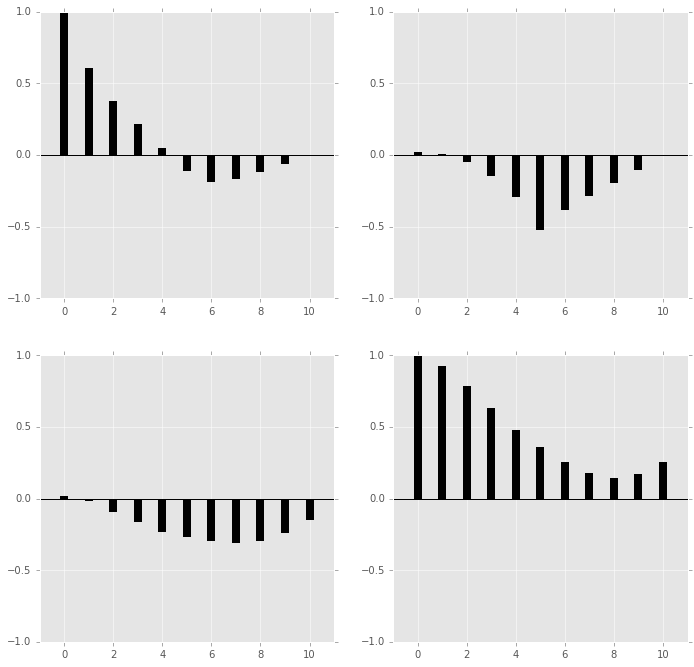

In [44]:
var_results.plot_acorr()

In [46]:
rfe = RFE(Ridge(alpha=1.0), step=5, n_features_to_select = 1)
np.mean(cross_val(rfe, X_train, y_train, cv_count=10))

-1121.6528861984507

In [47]:
rfe_fit = RFE(Ridge(alpha=1.0), step=5, n_features_to_select = 1).fit(X_train, y_train)

In [48]:
X_train.loc[:,rfe_fit.ranking_<=2].head()

,soi_window3_lag5,soi_window7_lag5,soi_window8_lag5,soi_window9_lag5,soi_window10_lag19
1868-07-01 00:00:00,0.752667,0.536429,0.472750,0.430556,0.0789
1868-08-01 00:00:00,0.690667,0.583286,0.541125,0.484000,0.1051
1868-09-01 00:00:00,0.395333,0.555143,0.511000,0.481556,0.1674
1868-10-01 00:00:00,0.351333,0.561286,0.545125,0.507000,0.1084
1868-11-01 00:00:00,0.227333,0.502000,0.516375,0.507000,0.0767


In [50]:
rfe_all = [np.mean(cross_val(
                                Ridge(alpha=1.0), 
                                X_train.loc[:,rfe_fit.ranking_<=i], 
                                y_train, 
                                cv_count=10))
     for i in range(1, max(rfe_fit.ranking_))]
best_index = np.array(rfe_all).argsort()[::-1][:1]
print 'Best nr of features = {}'.format(sum(rfe_fit.ranking_<=(best_index+1)))
print 'Which gives score   = {}'.format(rfe_all[best_index])

Best nr of features = 75
Which gives score   = -162.71530617


/Users/gerben/anaconda/envs/bdranalytics/lib/python2.7/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


## Final score
Choose your best pipeline and test its performance:

### Provided solution:

In [51]:
X_sub = X_train.loc[:, rfe_fit.ranking_<=(best_index+1)]
fit = Ridge(alpha=1.0).fit(X_sub, y_train)
test_predictions = fit.predict(X_test.loc[:, rfe_fit.ranking_ <= (best_index+1)])

### The score:

In [52]:
r2_score(y_test, test_predictions)

0.80540210268588697